## Set up

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import dataset

In [4]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Date,FuzzedDescription,UnitsSold,PricePerUnitPounds,RevenuePounds
0,2009-12-01,12 pencils small tube red spotty,45,0.76,34.20
1,2009-12-01,12 pencils tall tube posy,69,1.08,74.52
2,2009-12-01,12 pencils tall tube woodland,4,1.27,5.08
3,2009-12-01,3 stripey mice feltcraft,9,2.54,22.86
4,2009-12-01,6 ribbons rustic charm,27,2.67,72.09
...,...,...,...,...,...
48125,2010-12-09,wooden picture frame white finish,22,2.55,56.10
48126,2010-12-09,wooden school colouring set,13,2.50,32.50
48127,2010-12-09,woodland charlotte bag,5,1.25,6.25
48128,2010-12-09,world war 2 gliders asstd designs,52,0.36,18.72


## Prepare the dataset

In [11]:
# Using the pivoting process so that every product has the same
# number of timestamps.
pivoted_data = online_retail_df.pivot(index='Date', columns='FuzzedDescription', values='UnitsSold')
pivoted_data = pivoted_data.fillna(0)
pivoted_data

FuzzedDescription,12 pencils small tube red spotty,12 pencils tall tube posy,12 pencils tall tube woodland,3 stripey mice feltcraft,6 ribbons rustic charm,60 teatime fairy cake cases,72 sweetheart fairy cake cases,airline bag vintage jet set red,antique silver tea glass etched,assorted colour bird ornament,...,wood black board ant white finish,wood s3 cabinet ant white finish,wooden box of dominoes,wooden frame antique white,wooden happy birthday garland,wooden picture frame white finish,wooden school colouring set,woodland charlotte bag,world war 2 gliders asstd designs,zinc metal heart decoration
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,45.0,69.0,4.0,9.0,27.0,173.0,50.0,0.0,210.0,1272.0,...,0.0,5.0,18.0,38.0,0.0,30.0,0.0,34.0,48.0,66.0
2009-12-02,87.0,87.0,21.0,19.0,7.0,159.0,229.0,0.0,122.0,121.0,...,0.0,10.0,59.0,40.0,0.0,83.0,0.0,20.0,435.0,254.0
2009-12-03,34.0,116.0,13.0,101.0,3.0,201.0,83.0,0.0,158.0,312.0,...,0.0,26.0,58.0,46.0,21.0,48.0,0.0,10.0,56.0,104.0
2009-12-04,84.0,160.0,25.0,7.0,2.0,99.0,3.0,0.0,56.0,258.0,...,0.0,10.0,13.0,19.0,43.0,8.0,0.0,14.0,144.0,65.0
2009-12-05,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,24.0,...,0.0,26.0,0.0,48.0,0.0,54.0,0.0,0.0,48.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-05,151.0,6.0,15.0,4.0,49.0,9.0,19.0,8.0,148.0,129.0,...,49.0,3.0,20.0,30.0,13.0,39.0,17.0,42.0,96.0,34.0
2010-12-06,135.0,4.0,17.0,36.0,38.0,57.0,1.0,10.0,390.0,130.0,...,33.0,7.0,230.0,24.0,8.0,16.0,20.0,15.0,8.0,33.0
2010-12-07,20.0,15.0,9.0,9.0,37.0,30.0,28.0,10.0,162.0,271.0,...,1083.0,8.0,22.0,32.0,3.0,20.0,3.0,127.0,50.0,51.0


In [19]:
# The PyTorch TFT expects the time axis to be a 
# natural number, not datetime, so we format the
# data appropriately.
formatted_df = pivoted_data.reset_index().melt(id_vars="Date", 
                                               var_name="ProductId", 
                                               value_name="UnitsSold")
formatted_df = formatted_df.sort_values(['Date', 'ProductId'])
formatted_df.loc[:,'TimeIdx'] = formatted_df.groupby("ProductId").cumcount()
formatted_df = formatted_df[['TimeIdx', 'ProductId', 'UnitsSold']].reset_index()
formatted_df

,index,TimeIdx,ProductId,UnitsSold
0,0,0,12 pencils small tube red spotty,45.0
1,307,0,12 pencils tall tube posy,69.0
2,614,0,12 pencils tall tube woodland,4.0
3,921,0,3 stripey mice feltcraft,9.0
4,1228,0,6 ribbons rustic charm,27.0
...,...,...,...,...
60167,58943,306,wooden picture frame white finish,22.0
60168,59250,306,wooden school colouring set,13.0
60169,59557,306,woodland charlotte bag,5.0
60170,59864,306,world war 2 gliders asstd designs,52.0


['set of 72 pink heart paper doilies' 'door mat new england'
 'set 12 retro white chalk sticks' 'red spotty bowl']


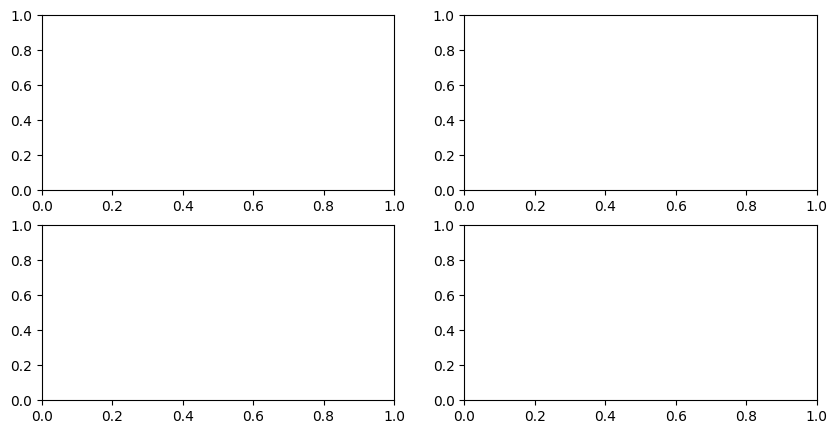

In [106]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

products_to_plot = np.random.choice(formatted_df['ProductId'], size=4)

for ax, product in zip(axs.flatten(), products_to_plot):
    df = (
        formatted_df
        .query(f'ProductId == "{product}"')
        .set_index('TimeIndex')
    )

In [83]:
training_cutoff = formatted_df['TimeIdx'].max() - 30  # Leave 30 days for validation
min_prediction_length = 1  # day
max_prediction_length = 30  # days
min_encoder_length = 30  # days
max_encoder_length = 30  # days

training_dataset = TimeSeriesDataSet(
    formatted_df[lambda x: x['TimeIdx'] <= training_cutoff],
    time_idx='TimeIdx',
    target='UnitsSold',
    group_ids=['ProductId'],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['ProductId'],
    static_reals=[],
    time_varying_known_categoricals=[],
     # group of categorical variables can be treated as one variable
    variable_groups={},
    time_varying_known_reals=['TimeIdx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['UnitsSold'],
    target_normalizer=GroupNormalizer(
        groups=['ProductId'], transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create a validation set (predict=True) which means to predict the last
# max_prediction_length points in time for each series.
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    formatted_df,
    predict=True,
    stop_randomization=True,
)

# Create dataloaders for the model
batch_size = 32
train_dataloader = training_dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

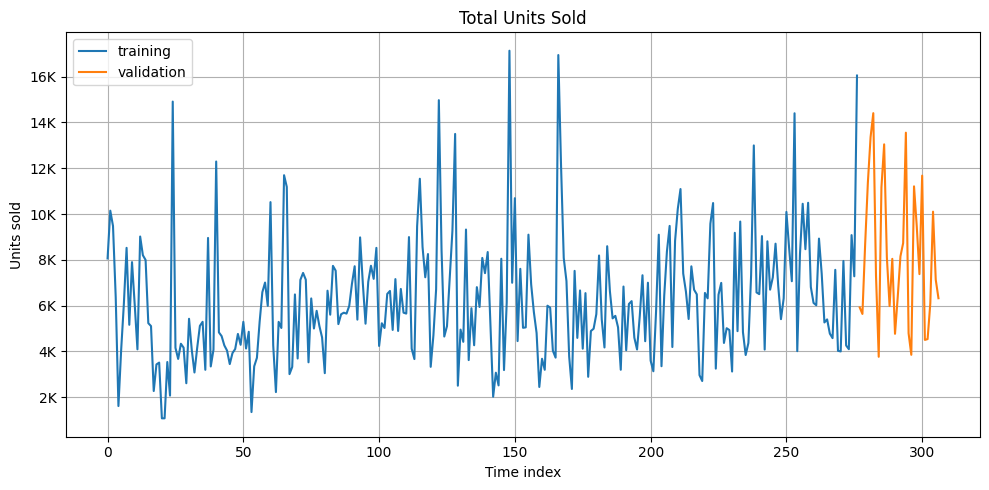

In [95]:
training_total = (
    formatted_df[lambda x: x['TimeIdx'] <= training_cutoff]
    .groupby('TimeIdx')['UnitsSold']
    .sum()
    .sort_index())
validation_total = (
    formatted_df[lambda x: x['TimeIdx'] > training_cutoff]
    .groupby('TimeIdx')['UnitsSold']
    .sum()
    .sort_index())

fig, ax = plt.subplots(figsize=(10,5))

training_total.plot(ax=ax, label='training')
validation_total.plot(ax=ax, label='validation')

ax.set_title('Total Units Sold')
ax.set_xlabel('Time index')
ax.set_ylabel('Units sold')
ax.legend()
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Baseline model

In [97]:
# Calculate a baseline mean absolute percentage error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(
    val_dataloader,
    return_y=True,
    return_index=True,
)
MAPE()(baseline_predictions.output, baseline_predictions.y)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(3.1129e+08, device='mps:0')

In [98]:
# Extract predictions and actuals
y_pred = baseline_predictions.output.cpu().numpy()
y_true = baseline_predictions.y[0].cpu().numpy()

index = baseline_predictions.index

In [99]:
y_true.shape

(196, 30)

In [100]:
y_pred.shape

(196, 30)

In [101]:
baseline_predictions.index['TimeIdx']

0      277
1      277
2      277
3      277
4      277
      ... 
191    277
192    277
193    277
194    277
195    277
Name: TimeIdx, Length: 196, dtype: int64